In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import Adam
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms.functional import resized_crop

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd 




In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [3]:
img_width = 224
img_height = 224


In [4]:
df = pd.read_csv("./data/labels.csv")

In [5]:
breeds = df.breed.unique()
map = {} 
for i, breed in enumerate(breeds):
    map[breed] = i

In [6]:
for breed in breeds: 
    print(map[breed], breed)

0 boston_bull
1 dingo
2 pekinese
3 bluetick
4 golden_retriever
5 bedlington_terrier
6 borzoi
7 basenji
8 scottish_deerhound
9 shetland_sheepdog
10 walker_hound
11 maltese_dog
12 norfolk_terrier
13 african_hunting_dog
14 wire-haired_fox_terrier
15 redbone
16 lakeland_terrier
17 boxer
18 doberman
19 otterhound
20 standard_schnauzer
21 irish_water_spaniel
22 black-and-tan_coonhound
23 cairn
24 affenpinscher
25 labrador_retriever
26 ibizan_hound
27 english_setter
28 weimaraner
29 giant_schnauzer
30 groenendael
31 dhole
32 toy_poodle
33 border_terrier
34 tibetan_terrier
35 norwegian_elkhound
36 shih-tzu
37 irish_terrier
38 kuvasz
39 german_shepherd
40 greater_swiss_mountain_dog
41 basset
42 australian_terrier
43 schipperke
44 rhodesian_ridgeback
45 irish_setter
46 appenzeller
47 bloodhound
48 samoyed
49 miniature_schnauzer
50 brittany_spaniel
51 kelpie
52 papillon
53 border_collie
54 entlebucher
55 collie
56 malamute
57 welsh_springer_spaniel
58 chihuahua
59 saluki
60 pug
61 malinois
62 kom

In [7]:
print(f"Number of dog breeds: {len(breeds)}")

Number of dog breeds: 120


In [8]:
def get_dim(img, target_dim):
    channels, height, width = img.size()
    if height <= width: 
        new_height = target_dim
        new_width = int(width * target_dim / height)
    else: 
        new_width = target_dim
        new_height = int(height * target_dim / width)
    return new_height, new_width


In [9]:
import random
class CustomDataset(Dataset):
    def __init__(self, csv_file, base_dir, map):
        self.annotations = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.annotations
        self.map = map

    def custom_transforms(self, img, target_dim):
        new_height, new_width = get_dim(img, target_dim)
        seq = T.Compose([
            T.Resize((new_height, new_width)),
            T.RandomHorizontalFlip(0.5),
            T.RandomGrayscale(0.2),
            T.RandomCrop((target_dim, target_dim)),
            T.RandomAdjustSharpness(0.2)
        ])
        return seq

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.base_dir + '/' + self.annotations.iloc[index, 0] + '.jpg'
        image = read_image(img_path)
        y_label = torch.tensor(self.map[self.annotations.iloc[index, 1]])
        # apply custom transforms
        image = self.custom_transforms(image, img_width)(image).float()
        return (image, y_label)
    

In [10]:
dataset = CustomDataset(
    csv_file="./data/labels.csv",
    base_dir="./data/train",
    map=map, 
    )






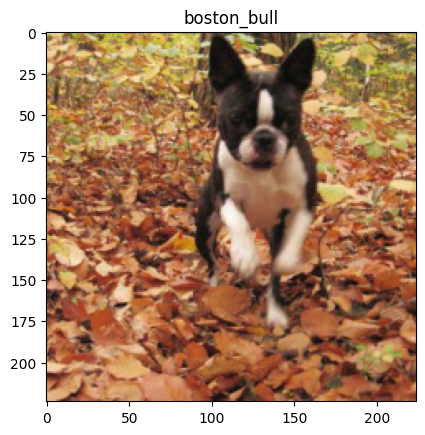

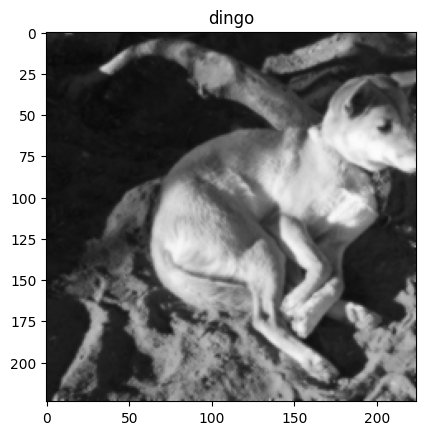

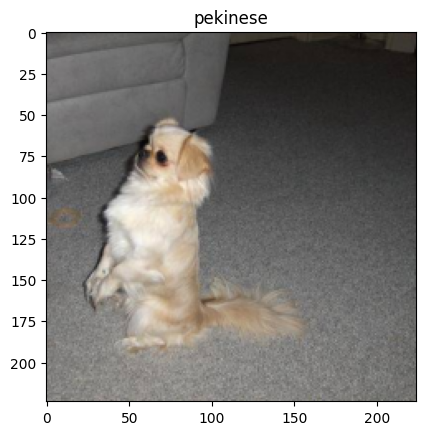

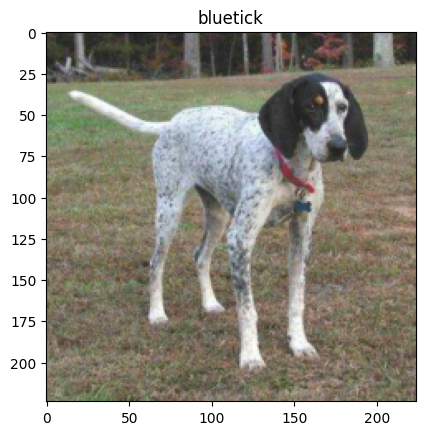

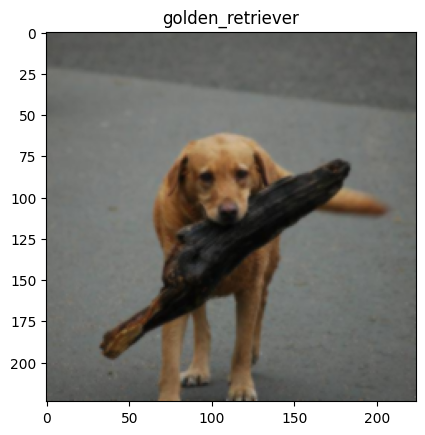

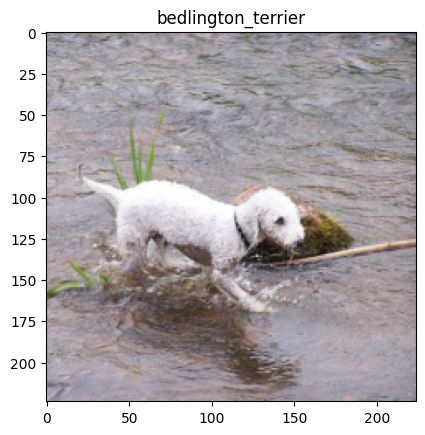

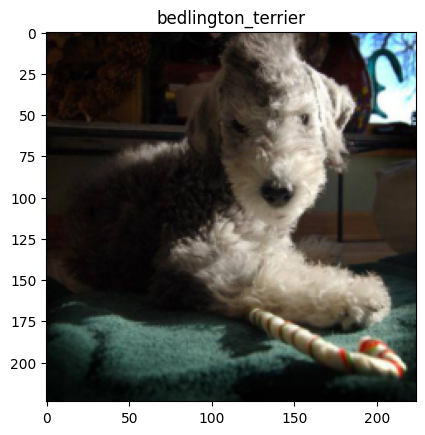

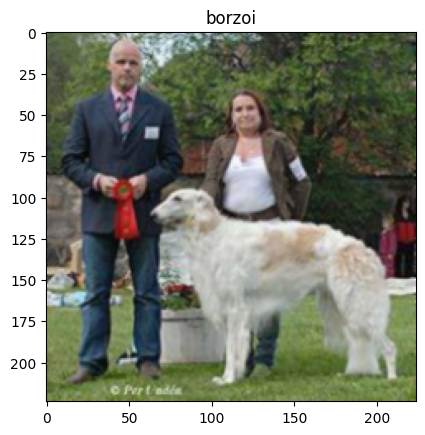

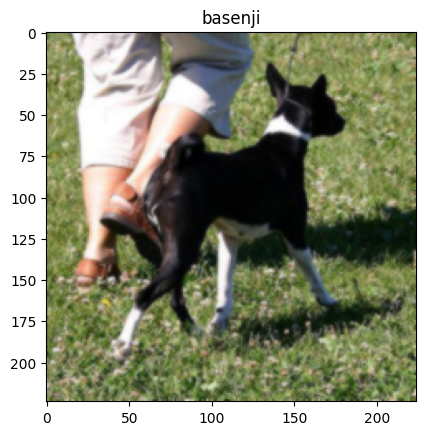

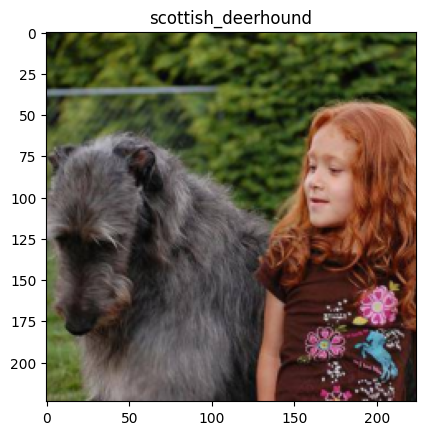

In [11]:
# see some images and labels 

for i in range(10): 
    image, label = dataset[i]
    plt.imshow(image.permute(1, 2, 0).int())
    plt.title(breeds[label])
    plt.show()

In [12]:
# split the dataset into train and test

train_size = int(0.95 * len(dataset))

test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


overfit_dataset = torch.utils.data.Subset(train_dataset, range(256))

In [13]:
len(overfit_dataset)

over_fit_loader = DataLoader(dataset=overfit_dataset, batch_size=256)

In [14]:
print(len(overfit_dataset))

256


In [15]:
print(len(train_dataset), len(test_dataset))

9710 512


In [16]:
def dim_after_pool(dim, kernel_size, stride, padding, layers): 
    if layers == 0:
        return dim
    dim = (dim - kernel_size + 2 * padding) / stride + 1
    dim = int(dim)
    return dim_after_pool(dim, kernel_size, stride, padding, layers - 1)

print(dim_after_pool(224, 2, 2, 0, 6))

3


In [17]:
class DogNet(nn.Module):
    def __init__(self):
        super(DogNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.conv4 = nn.Conv2d(40, 80, 3, 1, 1)
        self.conv5 = nn.Conv2d(80, 160, 3, 1, 1)
        self.conv6 = nn.Conv2d(160, 320, 3, 1, 1)

        self.mp = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(320 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 200)
        self.fc5 = nn.Linear(200, 120)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(200)

        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        x = F.relu(self.mp(self.conv4(x)))
        x = F.relu(self.mp(self.conv5(x)))
        x = F.relu(self.mp(self.conv6(x)))
        x = x.view(-1, 320 * 3 * 3)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)


        
        return x 

        

In [18]:
model = DogNet().to(device)

import torchsummary

torchsummary.summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 224, 224]        280
├─MaxPool2d: 1-2                         [-1, 10, 112, 112]        --
├─Conv2d: 1-3                            [-1, 20, 112, 112]        1,820
├─MaxPool2d: 1-4                         [-1, 20, 56, 56]          --
├─Conv2d: 1-5                            [-1, 40, 56, 56]          7,240
├─MaxPool2d: 1-6                         [-1, 40, 28, 28]          --
├─Conv2d: 1-7                            [-1, 80, 28, 28]          28,880
├─MaxPool2d: 1-8                         [-1, 80, 14, 14]          --
├─Conv2d: 1-9                            [-1, 160, 14, 14]         115,360
├─MaxPool2d: 1-10                        [-1, 160, 7, 7]           --
├─Conv2d: 1-11                           [-1, 320, 7, 7]           461,120
├─MaxPool2d: 1-12                        [-1, 320, 3, 3]           --
├─Linear: 1-13                           [-1, 512]              

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 224, 224]        280
├─MaxPool2d: 1-2                         [-1, 10, 112, 112]        --
├─Conv2d: 1-3                            [-1, 20, 112, 112]        1,820
├─MaxPool2d: 1-4                         [-1, 20, 56, 56]          --
├─Conv2d: 1-5                            [-1, 40, 56, 56]          7,240
├─MaxPool2d: 1-6                         [-1, 40, 28, 28]          --
├─Conv2d: 1-7                            [-1, 80, 28, 28]          28,880
├─MaxPool2d: 1-8                         [-1, 80, 14, 14]          --
├─Conv2d: 1-9                            [-1, 160, 14, 14]         115,360
├─MaxPool2d: 1-10                        [-1, 160, 7, 7]           --
├─Conv2d: 1-11                           [-1, 320, 7, 7]           461,120
├─MaxPool2d: 1-12                        [-1, 320, 3, 3]           --
├─Linear: 1-13                           [-1, 512]              

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, pin_memory=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

small_optimizer = Adam(model.parameters(), lr=0.0005)

In [20]:
small_optimizer = Adam(model.parameters(), lr=0.0005)

In [21]:
n_epochs = 37

model.train()
loss = 1 
opt = optimizer
for epoch in range(n_epochs):
    # print accuracy and loss every epoch
    correct = 0
    total = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader): 
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss.backward()
        opt.step()
    if opt != small_optimizer and running_loss / (i + 1) < 1:
        print("Switching to small optimizer")
        opt = small_optimizer
    print(f"Epoch: {epoch}, Loss: {running_loss / (i + 1)}, Accuracy: {100 * correct / total}")
    if running_loss / (i + 1) < 0.10:
        break



Epoch: 0, Loss: 4.758139723225644, Accuracy: 1.627188465499485


KeyboardInterrupt: 

In [114]:
# eval on overfit dataset
model.eval()
correct = 0
samples = 0
for img, label in train_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    correct += (output.argmax(1) == label).sum().item()
    samples += len(label)

print(f"Accuracy on test dataset: {correct / samples}")

Accuracy on test dataset: 0.7521112255406797


: 

In [25]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [22]:
??T.FiveCrop

Init signature: T.FiveCrop(size)
Source:        
class FiveCrop(torch.nn.Module):
    """Crop the given image into four corners and the central crop.
    If the image is torch Tensor, it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    .. Note::
         This transform returns a tuple of images and there may be a mismatch in the number of
         inputs and targets your Dataset returns. See below for an example of how to deal with
         this.

    Args:
         size (sequence or int): Desired output size of the crop. If size is an ``int``
            instead of sequence like (h, w), a square crop of size (size, size) is made.
            If provided a sequence of length 1, it will be interpreted as (size[0], size[0]).

    Example:
         >>> transform = Compose([
         >>>    FiveCrop(size), # this is a list of PIL Images
         >>>    Lambda(lambda crops: torch.stack([PILToTensor()(crop) for crop in crops])) # r

In [13]:
base_dir = "./data/train/"

# add img column to df containing the image data

df["img"] = df["id"].apply(lambda x: read_jpg(base_dir + x + ".jpg"))

In [14]:
df.head()

,id,breed,img
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,"[[[108, 46, 0], [152, 92, 42], [180, 120, 70],..."
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,"[[[51, 34, 26], [55, 38, 30], [61, 43, 33], [6..."
2,001cdf01b096e06d78e9e5112d419397,pekinese,"[[[97, 96, 91], [102, 101, 96], [108, 107, 102..."
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,"[[[71, 67, 66], [97, 93, 92], [84, 83, 81], [9..."
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,"[[[85, 87, 84], [85, 87, 84], [85, 87, 84], [8..."
